# The Monte Carlo Simulation of Radiation Transport

WE will discuss essentiall physics and method to do gamma quanta (photons with high enough energy) radiation transport using Monte Carlo methods. We will covers interactions processes, basics of radiation passing through matter as well as Monte Carlo method and how it helps with radiation propagation. 

## Glossary
- $h$ Plank's constant
- $\hbar$ reduced Plank's constant, $h/2\pi$
- $\omega$ photon circular frequency, 
- $\hbar \omega$ photon energy
- $\lambda$ photon wavelength
- $\theta$ scattering angle, between incoming and outgoing photon
- $\phi$ azimuthal angle
- $c$ speed of light in vacuum
- $m_e$ electron mass
- $r_e$ classical electron radius
- $N_A$ Avogadro Constant,  6.02214076$\times$10$^{23}$ mol$^{-1}$

## Basic physics

We would cover typical energies and wave length when photons are behaving like a point-like particle interaction with matter.

### Units

Common unit for a photon energy would be electron-volt (eV). This is the kinetic energy electron aquire when it moves in electric field (say, between plates of the capacitor) with potential difference 1Volt. This is very small energy and is equal to about $1.6\times10^{-19}$Joules. Typical energies we are interested inare in the 1keV to 100MeV range.

### Spatial size and wave length

Photons are massless particles, and it is very easy to compute photon "size" which is photon wavelength.
$$ \lambda = \frac{hc}{E_\gamma} = \frac{hc}{\hbar \omega} = \frac{2 \pi c}{\omega}$$
where $\lambda$ is wavelength, $h$ is Plank's constant, $c$ is speed of light and $E_\gamma$ is photon energy. For example, lets compute wavelength for photon with energy 1eV.

In [22]:
h = 6.625e-34
c = 3e8
hw = 1.0 * 1.6e-19 # eV
λ = h*c/hw
print(f"Photon wavelength = {λ*1.0e9} nanometers")

Photon wavelength = 1242.1875 nanometers


Thus, for 1keV photon we will get wave length about 1.2 nm, and for 1MeV photon we will get wave length about $1.2\times10^{-3}$nm.

FOr comparison, typical atom size is from 0.1nm (He) to 0.4nm (Fr and other heavy). Therefore, for most interactions between photon and atoms in our enery range we could consider it particles, not waves.

## Basics of Monte Carlo methods

Was first introduced by Conte du Buffon, as needle dropping experiment to calculate value of $\pi$. Laplace extended the example of the CduB by using sampling in the square to calculate value of $\pi$. It is a very general method of stochastic integration of the function. Was successfully applied to the particles (neutron in this case) transport by Enrico Fermi. Since growing applications of computers it is growing exponentially in use - finances, radiation therapy, machine learning, astrophysics, optimizations, younameit.

Let's try to calculate $\pi$ with the Laplace method, namely sampe points uniformly in the 

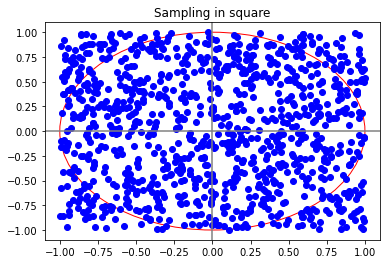

In [23]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

N = 1000 # number of points to sample

x = 2.0*np.random.random(N) - 1.0
y = 2.0*np.random.random(N) - 1.0

unitCircle = plt.Circle((0, 0), 1.0, color='r', fill=False)

fig, ax = plt.subplots(1, 1)

ax.plot(x, y, 'bo', label='Sampling in square')
ax.add_artist(unitCircle)
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')
plt.title("Sampling in square")
plt.show()


In [24]:
r = np.sqrt(x*x + y*y)
#print(r)
pinside = r[r<=1.0]
Ninside = len(pinside)
print(4.0*Ninside/N)

3.08


Result shall be close to $\pi$

## Basic Photons Interactions with atoms

There are several interaction processess of photons with media.

### Compton Scattering

Compton scattering is described by Klein-Nishina formula with energy of scattered photon directly tied to incoming energy and scattering angle
$$
\hbar \omega'=\frac{\hbar\omega}{1+\frac{\hbar \omega}{m_e c^2} (1 - \cos{\theta})}
$$
where prime marks particle after scattering. It is clear to see that for backscattering photon ($\theta=\pi$, $\cos{\theta}=-1$) the energy of scattered photon reach minimum, which means scattered photon energy has limits
$$
\frac{\hbar \omega }{1 + 2\hbar\omega/m_ec^2} \le \hbar\omega' \le \hbar\omega
$$

Scattering cross-section (you could think of this as denormalized probability to be scattered to a given enegy)
$$
\frac{d\sigma}{d\hbar\omega'} = \pi r_e^2 \frac{m_ec^2}{(\hbar\omega)^2} \lbrace \frac{\hbar\omega}{\hbar\omega'} + \frac{\hbar\omega'}{\hbar\omega} +
\left ( \frac{m_ec^2}{\hbar\omega'} - \frac{m_ec^2}{\hbar\omega} \right )^2 - 
2m_ec^2 \left ( \frac{1}{\hbar\omega'} - \frac{1}{\hbar\omega} \right ) \rbrace
$$

Full cross-section, where $x=2 \hbar\omega/m_e c^2$ is double relative photon enery.
$$
\sigma=2\pi r_e^2\frac{1}{x}\lbrace \left ( 1 - \frac{4}{x} - \frac{8}{x^2} \right ) \log{(1+x) +\frac{1}{2} + \frac{8}{x}-\frac{1}{2(1+x)^2}} \rbrace
$$

Then we could divide partial cross-section by total cross-section and get probability of scattered photon energy for different incoming photons. Lets plot few graphs. As one can see, cross-section has dimension of area. They are very small, therefore cross-sections are measured in barns, one barn being $10^-{24}$ centimeter squared.

Let's for reference add expression how to compute angular differential cross-section
$$
\frac{d\sigma}{d\omicron'} = \frac{1}{2} r_e^2 \left( \frac{\hbar\omega'}{\hbar\omega}\right)^2 \left(\frac{\hbar\omega}{\hbar\omega'} + \frac{\hbar\omega'}{\hbar\omega} - \sin^2{\theta}\right)
$$

Let's move to more appropriate units: energy would be always in MeV, unit of length for cross-sections would be in femtometers (1fm = $10^{-15}m$). Barn is 100 femtometers squa.

In [25]:
# usefule constants
MeC2 = 0.511 # in MeV
Re   = 2.82  # femtometers

In [26]:
# main functions to deal with cross-sections
def hw_prime(hw, cos_theta):
    """computes outgoing photon energy vs cosine of the scattered angle"""
    hwp = hw/(1.0 + (1.0 - cos_theta)*hw/MeC2)
    return hwp

def cosθ_from_hwp(hw, hwp):
    return 1.0 - (MeC2/hwp - MeC2/hw)

def hwp_minimum(hw):
    """Computes minimum scattere energy in MeV given incoming photon energy hw"""
    return hw/(1.0 + 2.0*hw/MeC2)

def total_cross_section(hw):
    """Klein-Nishina total cross-section, LDL p.358, eq (86.16)"""
    if hw <= 0.0:
        raise RuntimeError(f"Photon energy is negative: {hw}")
    x = 2.0 * hw / MeC2
    q = 1.0/x
    z = (1.0 + x)
    
    σ = 2.0*np.pi*Re*Re * q * ((1.0 - 4.0*q - 8.0*q*q)*np.log(z) + 0.5 + 8.0*q - 0.5/z/z)
    return σ

def diff_cross_section_dhwp(hw, hwp):
    """Differential cross-section over outgoing photon energy"""
    if hw <= 0.0:
        raise RuntimeError(f"Photon energy is negative or zero: {hw}")
        
    if hwp <= 0.0:
        raise RuntimeError(f"Scattered photon energy is negative or zero: {hwp}")

    if hwp < hwp_minimum(hw): # outgoing energy cannot be less than minimum allowed
        return 0.0

    ei = MeC2/hw
    eo = MeC2/hwp

    dσ_dhwp = np.pi*Re*Re * (ei/hw) * (ei/eo + eo/ei + (eo-ei)**2 - 2.0*(eo-ei))
    return dσ_dhwp

def diff_cross_section_dOp(hw, θ):
    """Differential cross-section over outgoing photon differential angle"""
    cst = np.cos(θ)
    hwp = hw_prime(hw, cst)
    rhw = hwp/hw
    dσ_dOp = 0.5*np.pi*Re*Re * rhw*rhw*(rhw + 1.0/rhw - (1.0 - cst)*(1.0 + cst))
    return dσ_dOp

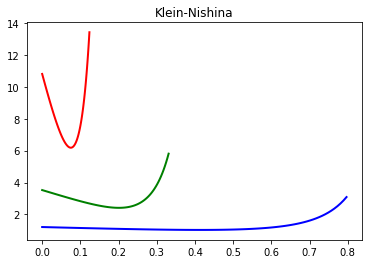

In [27]:
def make_energyloss_curve(hw):
    N = 101
    hwm = hwp_minimum(hw)
    hws = np.linspace(0.0, hw-hwm, N)
    st  = total_cross_section(hw)
    sc  = np.empty(101)
    for k in range(0, len(hws)):
        hwp = hw - hws[k]
        sc[k]  = diff_cross_section_dhwp(hw, hwp)/st

    return hws, sc

q_p25, s_p25 = make_energyloss_curve(0.25)
q_p50, s_p50 = make_energyloss_curve(0.50)
q_1p0, s_1p0 = make_energyloss_curve(1.00)

fig, ax = plt.subplots(1, 1)

ax.plot(q_p25, s_p25, 'r-', lw=2, label='Scattering probability vs energy loss, 0.25MeV')
ax.plot(q_p50, s_p50, 'g-', lw=2, label='Scattering probability vs energy loss, 0.50MeV')
ax.plot(q_1p0, s_1p0, 'b-', lw=2, label='Scattering probability vs energy loss, 1.00MeV')
plt.title("Klein-Nishina")
plt.show()

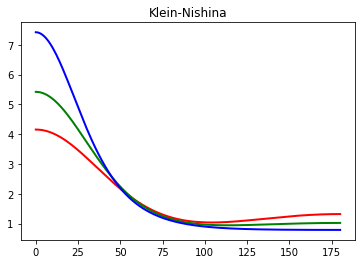

In [28]:
def make_angular_curve(hw):
    """Helper function to make angular probability x,y arrays given incoming photon enenrgy, MeV"""
    N = 181

    theta_d = np.linspace(0.0, 180.0, N) # angles in degrees
    theta_r = theta_d * np.pi / 180.0
    st = total_cross_section(hw)
    so = np.empty(N)

    for k in range(0, len(so)):
        so[k] = diff_cross_section_dOp(hw, theta_r[k]) * 2.0*np.pi / st

    return theta_d, so

a_p25, s_p25 = make_angular_curve(0.25)
a_p50, s_p50 = make_angular_curve(0.50)
a_1p0, s_1p0 = make_angular_curve(1.00)

fig, ax = plt.subplots(1, 1)

ax.plot(a_p25, s_p25, 'r-', lw=2, label='Scattering angular probability, 0.25MeV')
ax.plot(a_p50, s_p50, 'g-', lw=2, label='Scattering angular probability, 0.50MeV')
ax.plot(a_1p0, s_1p0, 'b-', lw=2, label='Scattering angular probability, 1.00MeV')
plt.title("Klein-Nishina")
plt.show()

## Cross-sections

### Microscopic and Macroscopic cross-sections

We learned about so-called microscopic cross-sections, which is oneabout one photon scattering on one electron. It is very small, measured in barns which is $10^{-24}$ cm$^2$. In real life photons interacti with material objects measured in grams and kilograms. For that, we need macroscopic cross-section. For macroscopic cross-section, we have to multiply microscopic one by $N$, which is density of scatterers, as well as atomic number $Z$ (remember, we are scattering on electrons)

For Compton scattering in water, we could write

$$
\Sigma = \rho Z \frac{N_A}{M} \sigma
$$

where $N_A$ is Avogadro constant, $M$ is molar mass (total mass of $N_A$ molecules) and $\rho$ is the density. Lets check the units. Suppose density is in $g/cm^3$, Avogadro Constant is in mol$^{-1}$ and molar mass is in $g/mol$. Therefore, macroscopic cross-section is measured in $cm^{-1}$ and gives the base for linear attenuation coefficient

$$
P(x) = \exp{(-\Sigma x)}
$$

where one can see that value under exponent is dimensionless.

### NIST cross-sections database

National Institute of Standards and Technologies provides a lot of precomputed corss-sections for elements and mixtures, for energies from 1keV up to 10GeV. One can find cross-sections from [XCOM place](https://www.nist.gov/pml/xcom-photon-cross-sections-database). One can pick elements, materials, mixtures and save them into local file. What is worth mentioning is that XCOM provides data as 

$$
\Sigma = Z \frac{N_A}{M}\sigma
$$

where density is specifically excluded. It is called mass attenuation coefficient. It is measured in $cm^2/g$. Using such units has certaint advantages, e.g. if you compute photon transport in media where density could change (say, inside nuclear reator where due to heating density of water goes from $\sim$ 1$\;g/cm^3$ to about 0.75$\;g/cm^3$) allows to keep intercation physics separate from density. Multiplying mass attenuation coefficient by density gives you back linear attenuation coefficient.

### Cross-sections for Water

Lets read water cross-sections and plot them

In [29]:
lines = None
with open('H2o.data', "r") as f: 
    lines = f.readlines()

header_len = 3

lines = lines[header_len:41] # remove header, and limit energy to 10MeV

energy = np.empty(len(lines)) # energy scale
coh_xs = np.empty(len(lines)) # coherent cross-section
inc_xs = np.empty(len(lines)) # incoherent cross-section
pht_xs = np.empty(len(lines)) # photo-effect cross-section
npp_xs = np.empty(len(lines)) # nuclear pair production
epp_xs = np.empty(len(lines)) # electron pair production

for k in range(0, len(lines)):
    s = lines[k].split('|')
    energy[k] = float(s[0])
    coh_xs[k] = float(s[1])
    inc_xs[k] = float(s[2])
    pht_xs[k] = float(s[3])
    npp_xs[k] = float(s[4])
    epp_xs[k] = float(s[5])

Now we will plot together photoeffect, coherent, incoherent and total mass attenuation cross-sections.

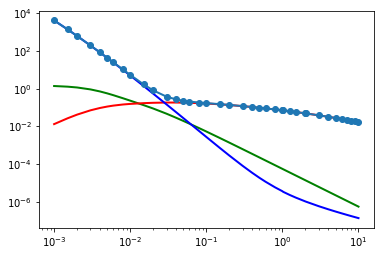

In [30]:
plt.xscale("log")
plt.yscale("log")
plt.plot(energy, coh_xs, 'g-', linewidth=2)
plt.plot(energy, inc_xs, 'r-', linewidth=2)
plt.plot(energy, pht_xs, 'b-', linewidth=2)
plt.plot(energy, pht_xs+coh_xs+inc_xs, 'o-', linewidth=2) # total cross-section
#plt.plot(energy, npp_xs, 'c-', linewidth=2)
#plt.plot(energy, epp_xs, 'm-', linewidth=2)
plt.show()

One can see that for all practical reasons considering only photo-effect and compton (aka incoherent) scatterin is good enough approximation,

## Compton Scattering Sampling

W will use Khan's method to sample Compton scattering.

In [31]:
def KhanComptonSampling(hw, rng):
    """Sample scattering energy after Compton interaction"""
    α = 2.0*hw/MeC2 # double relative incoming photon energy
    t = (α + 1.0)/(α + 9.0)

    x = 0.0
    while True:
        y = 1.0 + α*rng.random()
        if rng.random() < t:
            if rng.random() < 4.0*(1.0 - 1.0/y)/y:
                x = y
                break
        else:
             y = (1.0 + α) / y
             c = 2.0*y/α + 1.0
             if rng.random() < 0.5*(c*c + 1.0/y):
                x = y
                break
    return hw/x # scattered photon energy back

Let's test Compton sampling and compare it with microscopic differential cross-section

In [32]:
hw = 1.0 # MeV
hwm = hwp_minimum(hw)

Nt = 1000000
hwp = np.empty(Nt)
rng = np.random.default_rng(312345)

for k in range(0, len(hwp)):
   hwp[k] =  KhanComptonSampling(hw, rng)

Ok, lets check first the minimum energy in sampled values, should be within allowed range.

In [33]:
hwm_sampled = np.min(hwp)
print(f"Minimum allowed scattered energy: {hwm} vs actual sampled minimum {hwm_sampled}")
if hwm_sampled < hwm:
    print("We have a problem with kinematics!")

Minimum allowed scattered energy: 0.20350457984866588 vs actual sampled minimum 0.20350469296707585


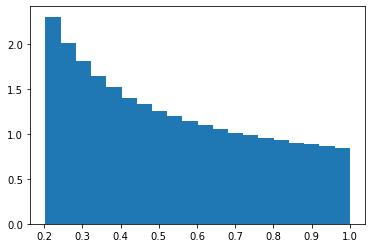

In [34]:
count, bins, ignored = plt.hist(hwp, 20, density=True)
plt.show()

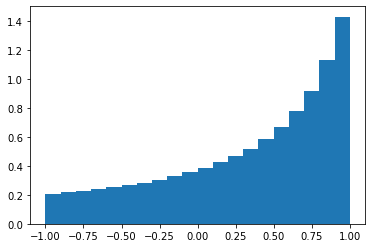

In [35]:
# plotting angular distribution
cosθ = cosθ_from_hwp(hw, hwp)
count, bins, ignored = plt.hist(cosθ, 20, density=True)
plt.show()

## Monte Carlo photon transport code

In [36]:
# several helper functions and constants
X = 0
Y = 1
Z = 2

def isotropic_source(rng):
    cosθ = 2.0*rng.random() - 1.0 # uniform cosine of the azimuth angle
    sinθ = np.sqrt((1.0 - cosθ)*(1.0 + cosθ))
    φ = 2.0*np.pi*rng.random() # uniform polar angle
    return np.array((sinθ*np.cos(φ), sinθ*np.sin(φ), cosθ))

def find_energy_index(scale, hw):
    return np.searchsorted(scale, hw, side='right') - 1

def calculate_xs(xs, scale, hw, idx):
    q = (hw - scale[idx])/(scale[idx+1] - scale[idx])
    return xs[idx]*(1.0 - q) + xs[idx+1]*q

def transform_cosines(wx, wy, wz, cosθ, φ):
    """https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/monte-carlo-methods-in-practice/monte-carlo-simulation"""
    # print(wx, wy, wz, cosθ)
    sinθ = np.sqrt((1.0 - cosθ)*(1.0 + cosθ))
    cosφ = np.cos(φ)
    sinφ = np.sin(φ)
    
    if wz == 1.0:
        return np.array((sinθ * cosφ, sinθ * sinφ, cosθ))
    
    if wz == -1.0:
        return np.array((sinθ * cosφ, -sinθ * sinφ, -cosθ))
    
    denom  = np.sqrt((1.0 - wz)*(1.0 + wz)) # denominator
    wzcosφ = wz * cosφ
    
    return np.array((wx * cosθ + sinθ * (wx * wzcosφ - wy * sinφ)/denom,
                     wy * cosθ + sinθ * (wy * wzcosφ + wx * sinφ)/denom,
                     wz * cosθ - denom * sinθ * cosφ))    

In [37]:
def is_inside(pos):
    """Check is photon is inside world box"""
    if pos[X] > 20.0:
        return False
    if pos[X] < -20.0:
        return False
    if pos[Y] > 20.0:
        return False
    if pos[Y] < -20.0:
        return False
    if pos[Z] > 20.0:
        return False
    if pos[Z] < -20.0:
        return False
    return True

# main MC loop
rng = np.random.default_rng(312345) # set RNG seed
    
Nt = 100 # number of trajectories

hw_src = 1.0 # initial energy, MeV
hw_max = energy[-1] # maximum energy in xs tables

pos_src = (0.0, 0.0, 0.0) # initial position
dir_src = (0.0, 0.0, 1.0) # initial direction

density = 1.0 # g/cm^3

for k in range(0, Nt): # loop over all trajectories
    
    print(f"Particle # {k}")
    
    # set energy, position and direction from source terms
    hw   = hw_src
    gpos = np.array(pos_src, dtype=np.float64)
    gdir = np.array(dir_src, dtype=np.float64) # could try isotropic source here
    
    if hw < 0.0:
        raise ValueError(f"Energy is negative: {hw}")
    if hw > hw_max:
        raise ValueError(f"Energy is too large: {hw}")    
    
    while True: # infinite loop over single trajectory till photon is absorbed or out of the box or out of energy range
        
        idx = find_energy_index(energy, hw)
        if idx < 0: # photon fell below 1keV energy threshold, kill it
            break
            
        phxs = calculate_xs(pht_xs, energy, hw, idx) # photo-effect cross-section
        inxs = calculate_xs(inc_xs, energy, hw, idx) # incoherent, aka Compton cross-section
        toxs = (phxs + inxs)                         # total cross-section
        
        pathlength  = - np.log(1.0 - rng.random()) # exponential distribution
        pathlength /= (toxs*density) # path length now in cm, because we move from mass attenuation toxs to linear attenuation
        
        #gpos = (gpos[X] + gdir[X]*pathlength, gpos[Y] + gdir[Y]*pathlength, gpos[Z] + gdir[Z]*pathlength) # move to the next interaction point
        gpos = gpos + np.multiply(gdir, pathlength)
        
        if not is_inside(gpos): # check if we are in volume of interest
            break # we'out, done with trajectory
            
        p_abs = phxs/toxs # probability of absorbtion
        if rng.random() < p_abs: # sample absorbtion
            break # photoeffect, photon is gone
            
        # compton scattering
        hwp  = KhanComptonSampling(hw, rng)
        cosθ = cosθ_from_hwp(hw, hwp)

        φ = 2.0*np.pi*rng.random() # uniform azimuth angle
        gdir = transform_cosines(*gdir, cosθ, φ)
        gdir = gdir/np.linalg.norm(gdir) # normalization
        
        hw = hwp
        # here we have new energy, new position and new direction

Particle # 0
Particle # 1
Particle # 2
Particle # 3
Particle # 4
Particle # 5
Particle # 6
Particle # 7
Particle # 8
Particle # 9
Particle # 10
Particle # 11
Particle # 12
Particle # 13
Particle # 14
Particle # 15
Particle # 16
Particle # 17
Particle # 18
Particle # 19
Particle # 20
Particle # 21
Particle # 22
Particle # 23
Particle # 24
Particle # 25
Particle # 26
Particle # 27
Particle # 28
Particle # 29
Particle # 30
Particle # 31
Particle # 32
Particle # 33
Particle # 34
Particle # 35
Particle # 36
Particle # 37
Particle # 38
Particle # 39
Particle # 40
Particle # 41
Particle # 42
Particle # 43
Particle # 44
Particle # 45
Particle # 46
Particle # 47
Particle # 48
Particle # 49
Particle # 50
Particle # 51
Particle # 52
Particle # 53
Particle # 54
Particle # 55
Particle # 56
Particle # 57
Particle # 58
Particle # 59
Particle # 60
Particle # 61
Particle # 62
Particle # 63
Particle # 64
Particle # 65
Particle # 66
Particle # 67
Particle # 68
Particle # 69
Particle # 70
Particle # 71
Pa